# Advanced Geographic Analysis

### Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [4]:
# Plotly template config
pio.templates.default = "plotly_white"

### Loading datasets

In [5]:
df_enrolment = pd.read_parquet('enrolment_cleaned.parquet')
df_demographic = pd.read_parquet('demographic_cleaned.parquet')
df_biometric = pd.read_parquet('biometric_cleaned.parquet')

### Analyze District Performance
##### Identify districts that are lagging behind by using a performance score
$Score= \frac{\text{district enrolment count}}{\text{average enrolment per district in that state}}$

--- Enrolments Analysis ---
Total Districts Analyzed: 985
Underserved Districts Found: 278


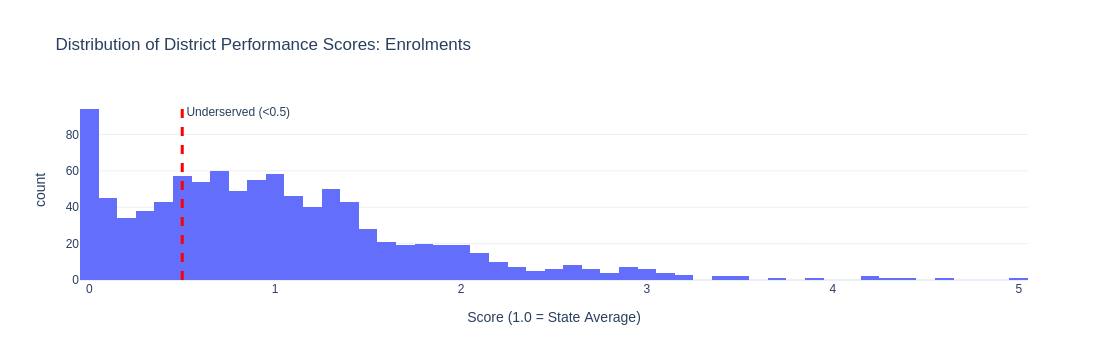


Top 10 Most Lagging Districts (Potential Outreach Targets):
              state            district  Volume    State_Avg  \
774      Tamil Nadu           Tiruvarur       1  1964.956522   
753      Tamil Nadu        Namakkal   *       1  1964.956522   
954     West Bengal             Hooghiy       1  1506.560000   
936     West Bengal  24 Paraganas South       1  1506.560000   
942     West Bengal             Burdwan       1  1506.560000   
951     West Bengal       East Midnapur       1  1506.560000   
523     Maharashtra           Hingoli *       1  1425.113208   
46   Andhra Pradesh      Visakhapatanam       1  1358.148936   
684       Rajasthan             Balotra       1  1306.285714   
718       Rajasthan            Salumbar       1  1306.285714   

     Performance_Score  
774           0.000509  
753           0.000509  
954           0.000664  
936           0.000664  
942           0.000664  
951           0.000664  
523           0.000702  
46            0.000736  
684      

,state,district,Volume,State_Avg,Performance_Score
0,Andaman And Nicobar Islands,Andamans,65,74.00,0.878378
1,Andaman And Nicobar Islands,Nicobar,37,74.00,0.500000
2,Andaman And Nicobar Islands,Nicobars,1,74.00,0.013514
3,Andaman And Nicobar Islands,North And Middle Andaman,96,74.00,1.297297
4,Andaman And Nicobar Islands,South Andaman,171,74.00,2.310811
...,...,...,...,...,...
980,West Bengal,South Dinajpur,242,1506.56,0.160631
981,West Bengal,South Twenty Four Parganas,1524,1506.56,1.011576
982,West Bengal,Uttar Dinajpur,1411,1506.56,0.936571
983,West Bengal,West Medinipur,2,1506.56,0.001328


In [9]:
def analyze_district_performance(df, dataset_name):
    # 1. Aggregate by State and District
    district_counts = df.groupby(['state', 'district']).size().reset_index(name='Volume')
    
    # 2. Calculate State Averages
    state_avg = district_counts.groupby('state')['Volume'].mean().reset_index(name='State_Avg')
    
    # 3. Merge and Calculate Score
    analysis_df = district_counts.merge(state_avg, on='state')
    analysis_df['Performance_Score'] = analysis_df['Volume'] / analysis_df['State_Avg']
    
    # 4. Filter for Underserved Districts (Score < 0.5)
    underserved = analysis_df[analysis_df['Performance_Score'] < 0.5].sort_values('Performance_Score')
    
    print(f"--- {dataset_name} Analysis ---")
    print(f"Total Districts Analyzed: {len(analysis_df)}")
    print(f"Underserved Districts Found: {len(underserved)}")
    
    # 5. Visualize the Distribution of Scores
    fig = px.histogram(
        analysis_df, 
        x="Performance_Score", 
        nbins=50,
        title=f"Distribution of District Performance Scores: {dataset_name}",
        labels={"Performance_Score": "Score (1.0 = State Average)"},
        color_discrete_sequence=['#636EFA']
    )
    # Add a line for the "Underserved" threshold
    fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="red", annotation_text="Underserved (<0.5)")
    fig.show()
    
    # 6. Show Top 10 Most Underserved (Lowest Scores)
    print("\nTop 10 Most Lagging Districts (Potential Outreach Targets):")
    print(underserved[['state', 'district', 'Volume', 'State_Avg', 'Performance_Score']].head(10))
    
    return analysis_df

# Run Analysis
analyze_district_performance(df_enrolment, "Enrolments")

### Metro vs. Tier-2/3 Analysis
##### Compare behavior in major metropolitan areas vs. smaller districts.

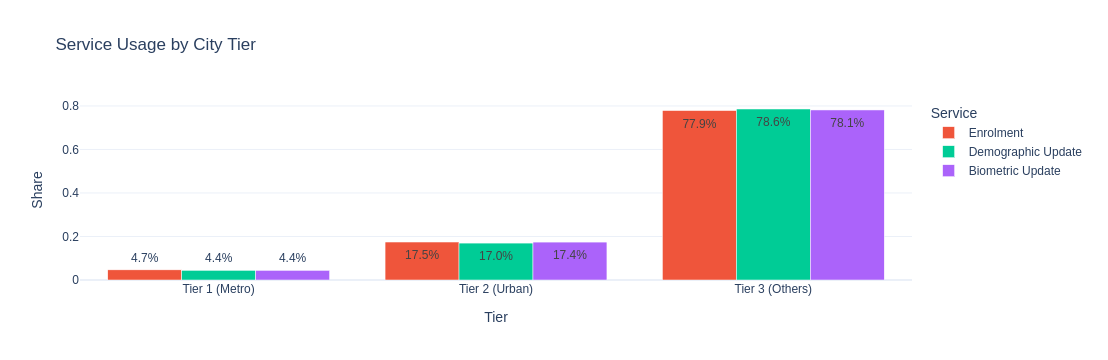

In [16]:
def classify_and_compare_tiers(df_enrol, df_demo, df_bio):
    
    # --- A. DEFINE OFFICIAL TIER LISTS ---
    # Tier 1 (Class X) - The 8 Metros
    tier_1_cities = [
        'Ahmedabad', 'Bengaluru', 'Bangalore', 'Chennai', 'Delhi', 
        'Hyderabad', 'Kolkata', 'Mumbai', 'Pune'
    ]
    
    # Tier 2 (Class Y) - Major selection of the ~97 cities
    tier_2_cities = [
        'Agra', 'Ajmer', 'Aligarh', 'Amravati', 'Amritsar', 'Asansol', 'Aurangabad', 
        'Bareilly', 'Belgaum', 'Bhavnagar', 'Bhiwandi', 'Bhopal', 'Bhubaneswar', 
        'Bikaner', 'Bilaspur', 'Chandigarh', 'Coimbatore', 'Cuttack', 'Dehradun', 
        'Dhanbad', 'Durgapur', 'Erode', 'Faridabad', 'Firozabad', 'Ghaziabad', 
        'Gorakhpur', 'Gulbarga', 'Guntur', 'Gwalior', 'Gurgaon', 'Gurugram', 
        'Guwahati', 'Hubli', 'Dharwad', 'Indore', 'Jabalpur', 'Jaipur', 'Jalandhar', 
        'Jammu', 'Jamnagar', 'Jamshedpur', 'Jhansi', 'Jodhpur', 'Kannur', 'Kanpur', 
        'Kochi', 'Kolhapur', 'Kollam', 'Kozhikode', 'Ludhiana', 'Lucknow', 'Madurai', 
        'Malappuram', 'Mangalore', 'Meerut', 'Moradabad', 'Mysore', 'Nagpur', 
        'Nanded', 'Nashik', 'Nellore', 'Noida', 'Patna', 'Pondicherry', 'Prayagraj', 
        'Allahabad', 'Raipur', 'Rajkot', 'Ranchi', 'Rourkela', 'Salem', 'Sangli', 
        'Siliguri', 'Solapur', 'Srinagar', 'Surat', 'Thiruvananthapuram', 'Thrissur', 
        'Tiruchirappalli', 'Tirunelveli', 'Ujjain', 'Vadodara', 'Varanasi', 
        'Vijayawada', 'Visakhapatnam', 'Warangal'
    ]

    # --- B. MAPPING FUNCTION ---
    def get_tier(district_name):
        if not isinstance(district_name, str): return 'Tier 3 (Others)'
        
        d_lower = district_name.lower()
        
        # Check Tier 1
        for city in tier_1_cities:
            if city.lower() in d_lower:
                return 'Tier 1 (Metro)'
        
        # Check Tier 2
        for city in tier_2_cities:
            if city.lower() in d_lower:
                return 'Tier 2 (Urban)'
                
        return 'Tier 3 (Others)'

    # --- C. APPLY MAPPING ---
    # Create copies to avoid SettingWithCopy warnings
    df_e = df_enrol.copy()
    df_d = df_demo.copy()
    df_b = df_bio.copy()
    
    df_e['City_Tier'] = df_e['district'].apply(get_tier)
    df_d['City_Tier'] = df_d['district'].apply(get_tier)
    df_b['City_Tier'] = df_b['district'].apply(get_tier)
    
    # --- D. AGGREGATE & COMPARE ---
    # Calculate share of volume per Tier
    enrol_dist = df_e['City_Tier'].value_counts(normalize=True).reset_index()
    enrol_dist.columns = ['Tier', 'Share']
    enrol_dist['Service'] = 'Enrolment'
    
    demo_dist = df_d['City_Tier'].value_counts(normalize=True).reset_index()
    demo_dist.columns = ['Tier', 'Share']
    demo_dist['Service'] = 'Demographic Update'

    bio_dist = df_b['City_Tier'].value_counts(normalize=True).reset_index()
    bio_dist.columns = ['Tier', 'Share']
    bio_dist['Service'] = 'Biometric Update'
    
    comparison = pd.concat([enrol_dist, demo_dist, bio_dist])
    
    # --- E. VISUALIZE ---
    fig = px.bar(
        comparison,
        x="Tier",
        y="Share",
        color="Service",
        barmode="group",
        title="Service Usage by City Tier",
        text_auto='.1%',
        color_discrete_sequence=["#EF553B", "#00CC96", "#AB63FA"],
        category_orders={"Tier": ["Tier 1 (Metro)", "Tier 2 (Urban)", "Tier 3 (Others)"]}
    )
    fig.show()

# Run the updated Tier analysis with all 3 datasets
classify_and_compare_tiers(df_enrolment, df_demographic, df_biometric)

### Border State Analysis
##### To analyze specific patterns in border states

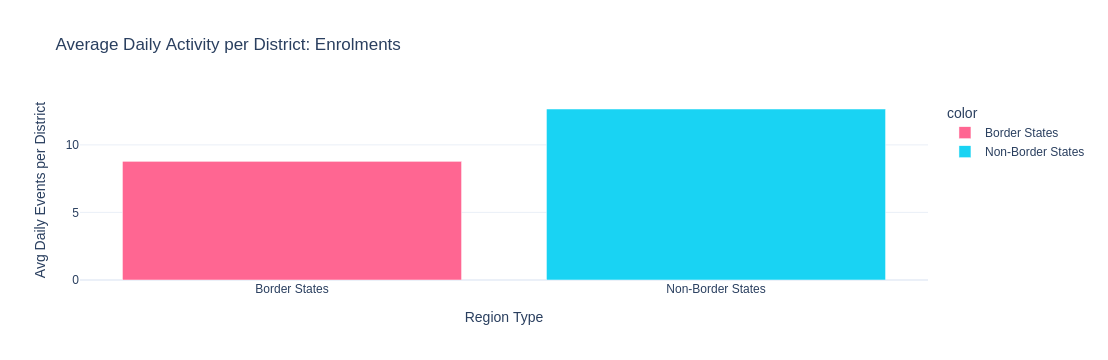

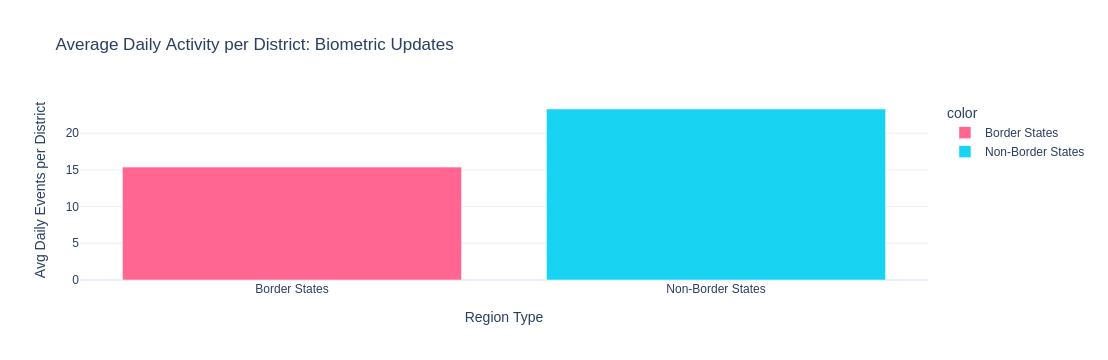

In [9]:
def analyze_border_states(df, title):
    # List of key border states
    border_states = [
        'Jammu And Kashmir', 'Punjab', 'Rajasthan', 
        'Gujarat', 'West Bengal', 'Assam', 'Arunachal Pradesh', 
        'Meghalaya', 'Tripura', 'Mizoram', 'Manipur', 'Nagaland', 'Ladakh'
    ]
    
    df_border = df[df['state'].isin(border_states)]
    df_non_border = df[~df['state'].isin(border_states)]
    
    # Metric: Average Daily Volume per District
    # (To compare intensity fairly)
    
    def get_avg_intensity(subset, label):
        # Count total events
        total_events = len(subset)
        # Count unique districts
        unique_districts = subset['district'].nunique()
        # Count unique days
        unique_days = subset['date'].nunique()
        
        if unique_districts == 0 or unique_days == 0: return 0
        
        # Avg events per district per day
        return total_events / (unique_districts * unique_days)

    intensity_border = get_avg_intensity(df_border, "Border States")
    intensity_others = get_avg_intensity(df_non_border, "Non-Border States")
    
    # Plot Comparison
    fig = px.bar(
        x=['Border States', 'Non-Border States'],
        y=[intensity_border, intensity_others],
        title=f"Average Daily Activity per District: {title}",
        labels={'y': 'Avg Daily Events per District', 'x': 'Region Type'},
        color=['Border States', 'Non-Border States'],
        color_discrete_sequence=['#FF6692', '#19D3F3']
    )
    fig.show()

analyze_border_states(df_enrolment, "Enrolments")
analyze_border_states(df_biometric, "Biometric Updates")